# Graph Embedding with SG-t-SNE-Pi

This notebook reproduces the [intro-graph demo](http://dimitris-floros.com/SGtSNEpi.jl/stable/intro-graph/) from the Julia SGtSNEpi.jl package.

**Key difference from the MNIST example:** here we start from a **pre-computed sparse graph**
(the `optdigits_10NN` kNN graph from the SuiteSparse Matrix Collection) — no feature extraction needed.
This is SG-t-SNE-Pi's core use case: embedding any sparse graph into low dimensions.

**Workflow:**
1. Download the `optdigits_10NN` graph from SuiteSparse
2. Embed into 2D with `sgtsnepi(A, d=2)`
3. Evaluate and visualize
4. (Optional) Embed into 3D

In [1]:
import os
import tarfile
import urllib.request

import numpy as np
from scipy.io import mmread

url = "https://suitesparse-collection-website.herokuapp.com/MM/ML_Graph/optdigits_10NN.tar.gz"
urllib.request.urlretrieve(url, "optdigits_10NN.tar.gz")
with tarfile.open("optdigits_10NN.tar.gz") as tar:
    tar.extractall()
os.remove("optdigits_10NN.tar.gz")

A = mmread("optdigits_10NN/optdigits_10NN.mtx").tocsc()
L = np.asarray(mmread("optdigits_10NN/optdigits_10NN_label.mtx")).ravel().astype(int)
print(f"Graph: {A.shape[0]} nodes, {A.nnz} edges, {len(set(L))} classes")

Graph: 5620 nodes, 79650 edges, 10 classes


## Parameter Mapping

The following table maps Julia SGtSNEpi.jl defaults to our Python `sgtsnepi()` API:

| Julia | Python | Value |
|-------|--------|-------|
| `d = 2` | `d=2` | 2 |
| `u = 10` | `lambda_=10` | 10 |
| `max_iter = 1000` | `max_iter=1000` | 1000 |
| `early_exag = 250` | `early_exag=250` | 250 |
| `alpha = 12` | `alpha=12` | 12 |
| `eta = 200` | `eta=200` | 200 |

Since the input is already a graph, we call `sgtsnepi(A)` directly — no kNN construction needed.

In [2]:
from pysgtsnepi.api import sgtsnepi

rng = np.random.default_rng(0)
Y0 = 0.01 * rng.standard_normal((A.shape[0], 2))
Y = sgtsnepi(A, d=2, Y0=Y0, random_state=0)
print(f"Embedding shape: {Y.shape}")

Embedding shape: (5620, 2)


In [3]:
from sklearn.metrics import silhouette_score
from sklearn.neighbors import KNeighborsClassifier

# kNN accuracy in embedding space
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(Y, L)
knn_acc = knn.score(Y, L)

# Silhouette score
rng = np.random.RandomState(42)
idx = rng.choice(len(Y), size=min(5000, len(Y)), replace=False)
sil = silhouette_score(Y[idx], L[idx])

print(f"kNN accuracy (k=10): {knn_acc:.4f}")
print(f"Silhouette score: {sil:.4f}")

kNN accuracy (k=10): 0.9865
Silhouette score: 0.4542


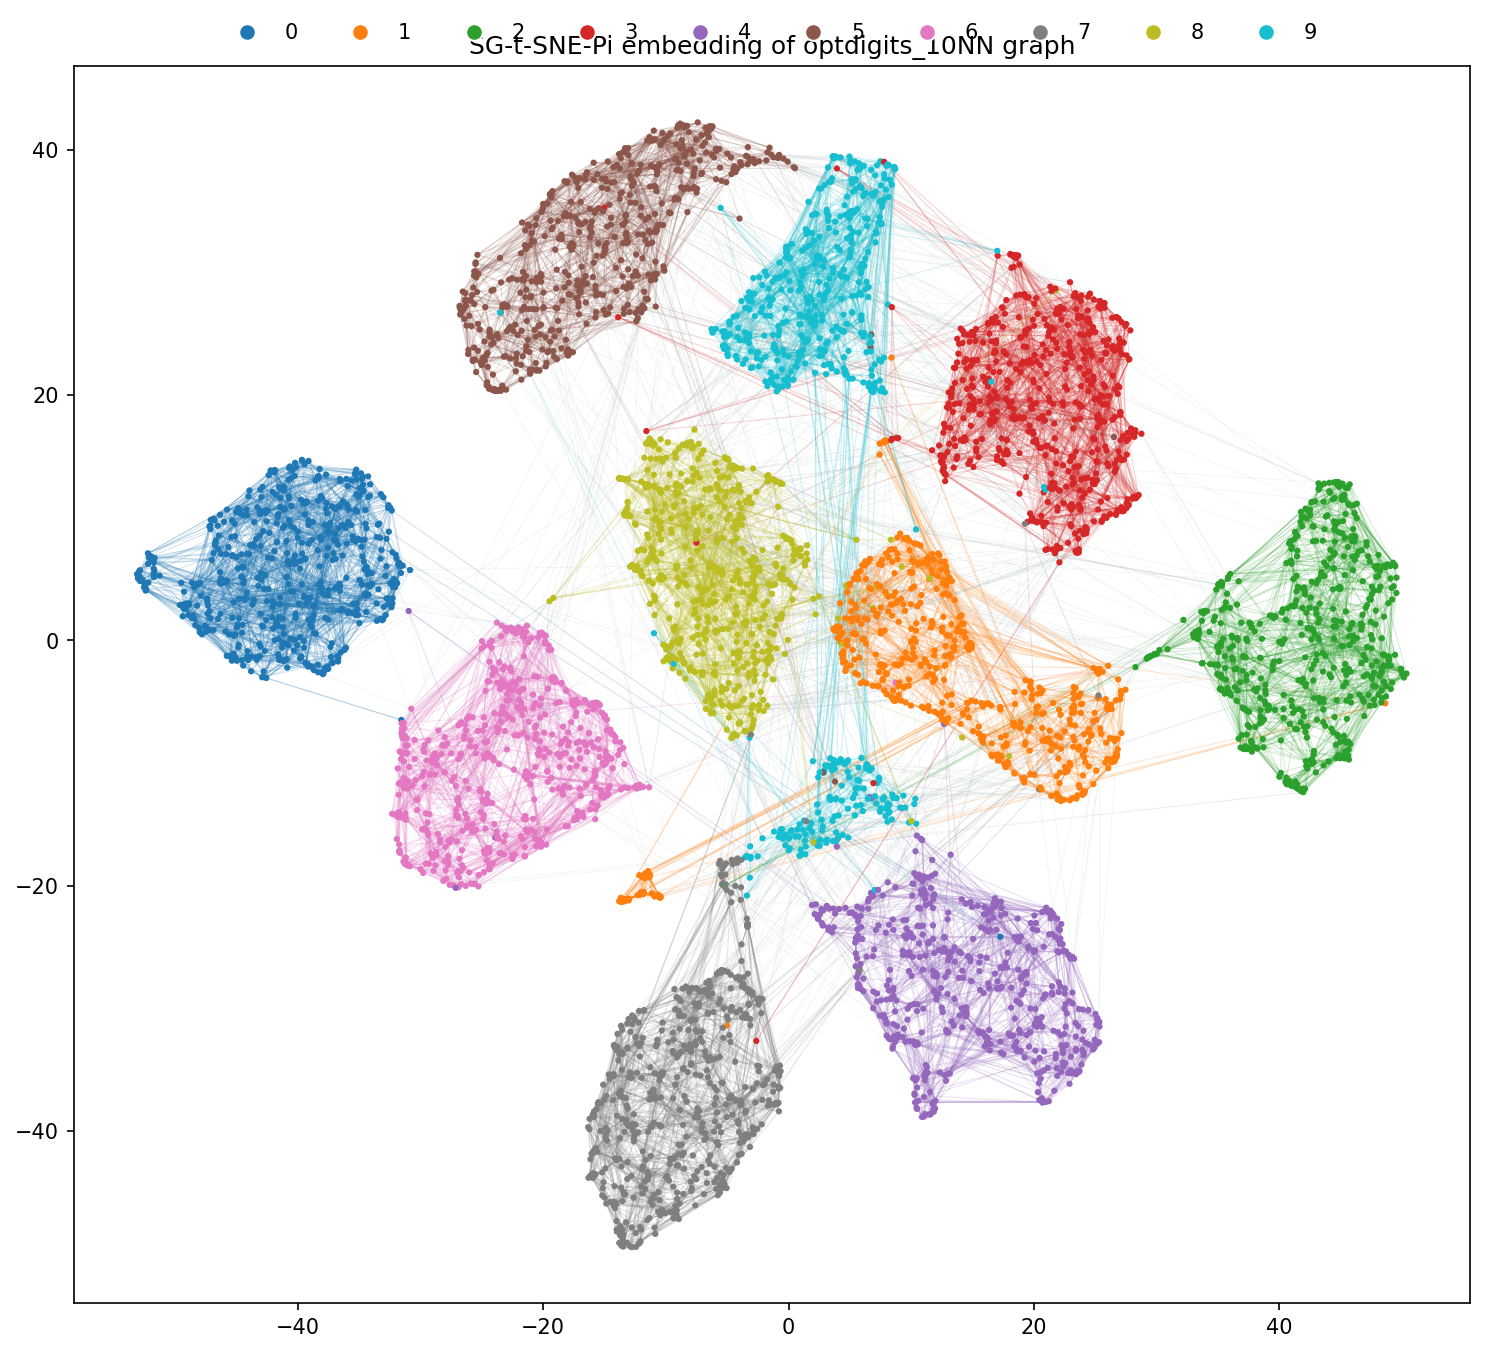

In [4]:
import matplotlib.pyplot as plt

from pysgtsnepi.vis import show_embedding

fig, ax = show_embedding(Y, L, A=A)
ax.set_title("SG-t-SNE-Pi embedding of optdigits_10NN graph")
plt.tight_layout()
plt.show()

## Results

The embedding should show well-separated digit clusters, comparable to the Julia reference.
Unlike the MNIST point-cloud example, no feature extraction was needed — we embedded the
graph directly. This demonstrates SG-t-SNE-Pi's core capability: embedding any sparse graph
into low dimensions for visualization.

3D Embedding shape: (5620, 3)


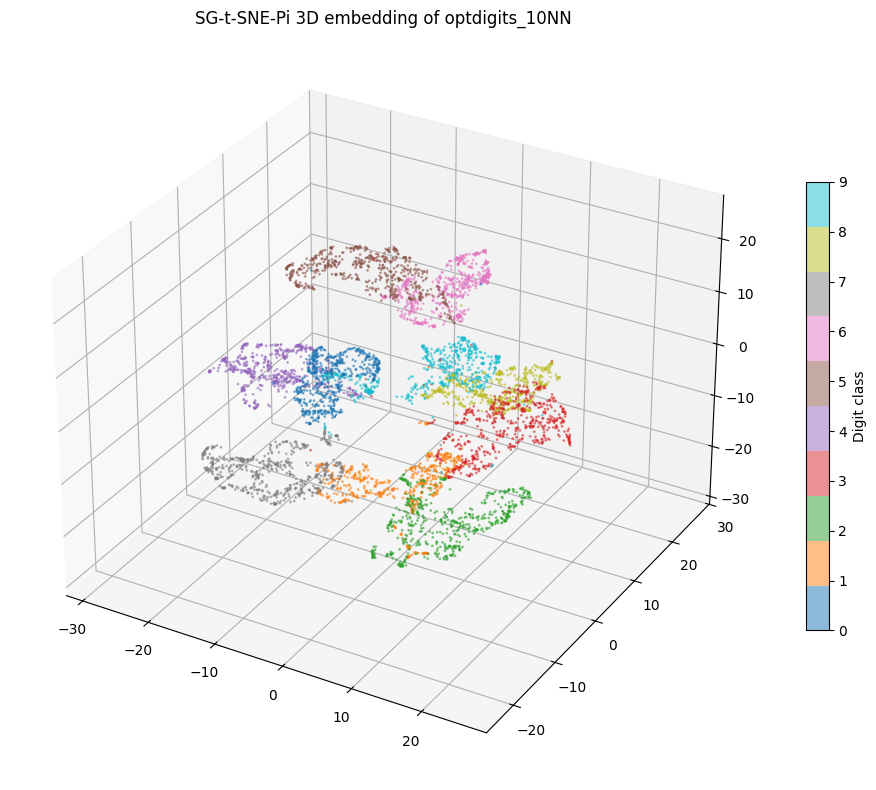

In [5]:
rng3 = np.random.default_rng(0)
Y0_3d = 0.01 * rng3.standard_normal((A.shape[0], 3))
Y3 = sgtsnepi(A, d=3, max_iter=500, Y0=Y0_3d, random_state=0)
print(f"3D Embedding shape: {Y3.shape}")

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(
    Y3[:, 0], Y3[:, 1], Y3[:, 2],
    c=L, cmap="tab10",
    s=1, alpha=0.5,
)
ax.set_title("SG-t-SNE-Pi 3D embedding of optdigits_10NN")
cbar = fig.colorbar(scatter, ax=ax, shrink=0.6)
cbar.set_label("Digit class")
plt.tight_layout()
plt.show()

In [6]:
import shutil

shutil.rmtree("optdigits_10NN", ignore_errors=True)